<a href="https://colab.research.google.com/github/valthoraval/stochastic/blob/master/Project_Market_Day_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Market Day

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

![Stardew Valley](https://venturebeat.com/wp-content/uploads/2018/01/sw7rtba7p1xs77klsime.png)

It is Market Day! You've been working hard for a whole season, planting, watering, and taking care of crops. Now it is time to sell them in town. Just one problem though - your old truck can only carry so much weight. Which crops should you bring to maximize your profits? 

In this project, you will use a stochastic algorithm of your choice to find the best crop configuration you can load into your truck. You know how much stock you have of each crop, how much each crop weighs, and what price it will fetch at the market. You should use these values throughout the project.

Before we start, if you're using colab to run this notebook, you'll need to uncomment and run the following lines:

In [3]:
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
!wget https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
!pip install pymoo

--2022-12-12 16:26:18--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/market.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927 [text/plain]
Saving to: ‘market.csv’

market.csv          100%[===================>]     927  --.-KB/s    in 0s      

2022-12-12 16:26:18 (32.1 MB/s) - ‘market.csv’ saved [927/927]

--2022-12-12 16:26:18--  https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/project/recipes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388 [text/plain]
Savin

In [4]:
import numpy as np
import pandas as pd
import pymoo
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import random

In [5]:
df = pd.read_csv('market.csv', index_col=0)
df.head()

,stock,weight,price_A,price_B,price_C
Apple,5,5,1.00,0.5,1.1
Apricot,65,3,0.50,0.2,0.6
Blueberry,5,3,0.50,0.3,1.2
Cactus Fruit,90,4,0.75,0.3,0.3
Cherry,15,4,0.80,0.4,1.1


In [6]:
stock = df['stock'].to_dict()
weight = df['weight'].to_dict()
price = df['price_A'].to_dict()

In [7]:
stock

{'Apple': 5,
 'Apricot': 65,
 'Blueberry': 5,
 'Cactus Fruit': 90,
 'Cherry': 15,
 'Cranberry': 75,
 'Grape': 70,
 'Melon': 75,
 'Orange': 40,
 'Peach': 55,
 'Pomegranate': 5,
 'Rhubarb': 70,
 'Starfruit': 5,
 'Strawberry': 20,
 'Amaranth': 20,
 'Artichoke': 65,
 'Beet': 30,
 'Bok Choy': 55,
 'Cauliflower': 70,
 'Corn': 90,
 'Eggplant': 95,
 'Garlic': 95,
 'Green Bean': 55,
 'Hops': 75,
 'Hot Pepper': 25,
 'Kale': 5,
 'Parsnip': 10,
 'Potato': 55,
 'Pumpkin': 30,
 'Radish': 50,
 'Red Cabbage': 55,
 'Tomato': 65,
 'Wheat': 75,
 'Yam': 50,
 'Blackberry': 70}

To evaluate your possible load going to the market, we will use a function that takes in a dictionary of this type, specifying how many of each crop you will take. This function will take into the constraints of having enough stock of the crop type and of not surpassing the weight limit.

In [8]:
def evaluate(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    for k in load:
        if load[k] <= stock[k]:
            total_price += load[k] * price[k]
            total_weight += load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

In [10]:
def toDict(lst):
    res_dct = {lst[i][0] : lst[i][1] for i in range(0, len(lst))}
    return res_dct

You can try this with an example load generated randomly:

In [11]:
trial_load = {}

for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])

In [12]:
print(trial_load)
type(trial_load)
print(list(trial_load.items())[:10])
dict_1 = toDict(list(trial_load.items())[:10])
print(dict_1)
dict_2 = toDict(list(trial_load.items())[10:])
print(dict_2)
print({**dict_1, **dict_2})

{'Apple': 2, 'Apricot': 45, 'Blueberry': 2, 'Cactus Fruit': 64, 'Cherry': 0, 'Cranberry': 54, 'Grape': 42, 'Melon': 11, 'Orange': 23, 'Peach': 37, 'Pomegranate': 2, 'Rhubarb': 67, 'Starfruit': 1, 'Strawberry': 10, 'Amaranth': 1, 'Artichoke': 37, 'Beet': 22, 'Bok Choy': 31, 'Cauliflower': 52, 'Corn': 71, 'Eggplant': 17, 'Garlic': 30, 'Green Bean': 1, 'Hops': 16, 'Hot Pepper': 19, 'Kale': 1, 'Parsnip': 8, 'Potato': 36, 'Pumpkin': 2, 'Radish': 19, 'Red Cabbage': 13, 'Tomato': 52, 'Wheat': 18, 'Yam': 48, 'Blackberry': 9}
[('Apple', 2), ('Apricot', 45), ('Blueberry', 2), ('Cactus Fruit', 64), ('Cherry', 0), ('Cranberry', 54), ('Grape', 42), ('Melon', 11), ('Orange', 23), ('Peach', 37)]
{'Apple': 2, 'Apricot': 45, 'Blueberry': 2, 'Cactus Fruit': 64, 'Cherry': 0, 'Cranberry': 54, 'Grape': 42, 'Melon': 11, 'Orange': 23, 'Peach': 37}
{'Pomegranate': 2, 'Rhubarb': 67, 'Starfruit': 1, 'Strawberry': 10, 'Amaranth': 1, 'Artichoke': 37, 'Beet': 22, 'Bok Choy': 31, 'Cauliflower': 52, 'Corn': 71, 'Egg

In [13]:
print(list(trial_load.values())[5])
print(list(trial_load.keys())[5])
trial_2 = trial_load.copy()
print(trial_2)
trial_2.update({str(list(trial_load.keys())[5]):20})
print(trial_2)

54
Cranberry
{'Apple': 2, 'Apricot': 45, 'Blueberry': 2, 'Cactus Fruit': 64, 'Cherry': 0, 'Cranberry': 54, 'Grape': 42, 'Melon': 11, 'Orange': 23, 'Peach': 37, 'Pomegranate': 2, 'Rhubarb': 67, 'Starfruit': 1, 'Strawberry': 10, 'Amaranth': 1, 'Artichoke': 37, 'Beet': 22, 'Bok Choy': 31, 'Cauliflower': 52, 'Corn': 71, 'Eggplant': 17, 'Garlic': 30, 'Green Bean': 1, 'Hops': 16, 'Hot Pepper': 19, 'Kale': 1, 'Parsnip': 8, 'Potato': 36, 'Pumpkin': 2, 'Radish': 19, 'Red Cabbage': 13, 'Tomato': 52, 'Wheat': 18, 'Yam': 48, 'Blackberry': 9}
{'Apple': 2, 'Apricot': 45, 'Blueberry': 2, 'Cactus Fruit': 64, 'Cherry': 0, 'Cranberry': 20, 'Grape': 42, 'Melon': 11, 'Orange': 23, 'Peach': 37, 'Pomegranate': 2, 'Rhubarb': 67, 'Starfruit': 1, 'Strawberry': 10, 'Amaranth': 1, 'Artichoke': 37, 'Beet': 22, 'Bok Choy': 31, 'Cauliflower': 52, 'Corn': 71, 'Eggplant': 17, 'Garlic': 30, 'Green Bean': 1, 'Hops': 16, 'Hot Pepper': 19, 'Kale': 1, 'Parsnip': 8, 'Potato': 36, 'Pumpkin': 2, 'Radish': 19, 'Red Cabbage': 

In [14]:
evaluate(trial_load, stock, weight, price)

776.0

## Challenge 1

Use a stochastic algorithm to find the configuration of crops that maximizes profit while respecting the constraints of the weight limit and stock. You can use any of the class code or a library like `pymoo`. You should create a reasonable representation for the problem and appropriate modification functions like mutation and crossover. You can also modify the evaluation function, as long as your final solution is valid according to the weight and stock constraints.

Include your code for optimization, any visualizations of the optimization process, as well as code to show the final market load and profit gained. Can you beat the random trial load profits?

Hint: this is a constrained case of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem)

In [15]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)
#trial_load
len(population_trail_load)
print(population_trail_load[20])
print(type(population_trail_load[20]))

print(len(population_trail_load))

{'Apple': 4, 'Apricot': 5, 'Blueberry': 1, 'Cactus Fruit': 49, 'Cherry': 7, 'Cranberry': 74, 'Grape': 55, 'Melon': 54, 'Orange': 27, 'Peach': 47, 'Pomegranate': 0, 'Rhubarb': 60, 'Starfruit': 3, 'Strawberry': 8, 'Amaranth': 10, 'Artichoke': 43, 'Beet': 27, 'Bok Choy': 52, 'Cauliflower': 27, 'Corn': 84, 'Eggplant': 54, 'Garlic': 10, 'Green Bean': 18, 'Hops': 58, 'Hot Pepper': 13, 'Kale': 2, 'Parsnip': 1, 'Potato': 9, 'Pumpkin': 21, 'Radish': 44, 'Red Cabbage': 37, 'Tomato': 52, 'Wheat': 46, 'Yam': 44, 'Blackberry': 28}
<class 'dict'>
100


In [16]:
def evaluate_population(population):
    fit = []
    for i in range(len(population)):
        prix = evaluate(population[i], stock, weight, price)
        fit.append(prix)
    return fit

In [17]:
fitness = evaluate_population(population_trail_load)
print(fitness)

[712.0, 0, 715.2000000000002, 716.2, 670.2000000000002, 663.3999999999999, 566.7500000000001, 655.7, 663.6500000000001, 668.4499999999998, 726.3499999999999, 0, 556.7, 650.5500000000002, 685.85, 610.4000000000001, 606.6, 506.70000000000005, 607.45, 814.2499999999999, 0, 688.8000000000001, 666.0500000000001, 683.5999999999999, 704.0500000000002, 606.35, 845.3000000000001, 704.65, 725.1000000000001, 743.3000000000001, 699.8, 706.3000000000001, 814.3000000000003, 0, 711.75, 732.8000000000002, 600.5, 674.05, 581.5500000000002, 780.9, 635.25, 795.6499999999999, 740.3499999999999, 648.6500000000001, 748.0, 710.0000000000001, 662.1, 704.7999999999998, 787.9499999999999, 673.4, 676.4, 635.7999999999998, 733.5500000000001, 675.6500000000001, 615.3000000000001, 0, 747.3499999999999, 715.9000000000002, 711.4, 482.09999999999997, 606.15, 673.3, 684.3500000000001, 729.8999999999999, 651.05, 0, 566.7, 0, 592.35, 650.9499999999999, 871.8000000000001, 826.1000000000003, 475.8, 797.5499999999996, 748.1

In [20]:
def truncation_selection(population, fitness, p=0.2):
    n_elites = len(population) - int(np.floor(len(population) * p))
    #print(n_elites)
    elites = np.argsort(np.array(fitness))[n_elites:]
    selected_pop, selected_fitness = [], []
    for index in elites:
        selected_pop.append(population[index])
        selected_fitness.append(fitness[index])
    return selected_pop, selected_fitness

elites [{'Apple': 3, 'Apricot': 32, 'Blueberry': 1, 'Cactus Fruit': 61, 'Cherry': 12, 'Cranberry': 56, 'Grape': 40, 'Melon': 24, 'Orange': 10, 'Peach': 37, 'Pomegranate': 1, 'Rhubarb': 18, 'Starfruit': 1, 'Strawberry': 10, 'Amaranth': 4, 'Artichoke': 49, 'Beet': 0, 'Bok Choy': 49, 'Cauliflower': 33, 'Corn': 32, 'Eggplant': 50, 'Garlic': 81, 'Green Bean': 36, 'Hops': 55, 'Hot Pepper': 10, 'Kale': 2, 'Parsnip': 7, 'Potato': 45, 'Pumpkin': 5, 'Radish': 42, 'Red Cabbage': 10, 'Tomato': 23, 'Wheat': 41, 'Yam': 21, 'Blackberry': 22}, {'Apple': 3, 'Apricot': 44, 'Blueberry': 1, 'Cactus Fruit': 63, 'Cherry': 14, 'Cranberry': 24, 'Grape': 16, 'Melon': 62, 'Orange': 12, 'Peach': 41, 'Pomegranate': 0, 'Rhubarb': 55, 'Starfruit': 1, 'Strawberry': 6, 'Amaranth': 5, 'Artichoke': 5, 'Beet': 7, 'Bok Choy': 31, 'Cauliflower': 65, 'Corn': 21, 'Eggplant': 4, 'Garlic': 55, 'Green Bean': 17, 'Hops': 44, 'Hot Pepper': 12, 'Kale': 0, 'Parsnip': 7, 'Potato': 12, 'Pumpkin': 13, 'Radish': 42, 'Red Cabbage': 52,

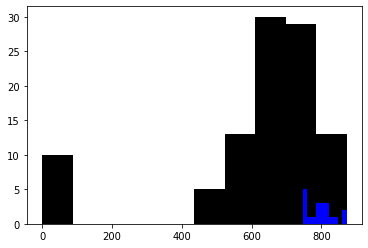

In [21]:
p_elites, efit = truncation_selection(population_trail_load, fitness)
plt.hist(fitness, color='k')
plt.hist(efit, color='b');
print('elites',p_elites,len(p_elites))
print(len(p_elites), len(efit), len(population_trail_load), len(fitness))

In [22]:
def tournament_selection(population, fitness, t_size=3):
    rng = np.random.default_rng()
    tournament = rng.choice(len(population), size=t_size)
    #print('tournament',type(tournament))
    #print('tournament', tournament)
    ind = []
    for i in range(len(tournament)):
        ind.append(fitness[tournament[i]])
    ind = ind.index(max(ind))
    return population[ind], fitness[ind]


In [23]:
for j in range(5):
    p, f = tournament_selection(population_trail_load, fitness, t_size=3)
    print(p)
    print(f)

{'Apple': 0, 'Apricot': 56, 'Blueberry': 1, 'Cactus Fruit': 83, 'Cherry': 3, 'Cranberry': 54, 'Grape': 56, 'Melon': 65, 'Orange': 18, 'Peach': 19, 'Pomegranate': 0, 'Rhubarb': 43, 'Starfruit': 4, 'Strawberry': 0, 'Amaranth': 13, 'Artichoke': 30, 'Beet': 20, 'Bok Choy': 52, 'Cauliflower': 60, 'Corn': 6, 'Eggplant': 84, 'Garlic': 35, 'Green Bean': 10, 'Hops': 65, 'Hot Pepper': 24, 'Kale': 3, 'Parsnip': 7, 'Potato': 28, 'Pumpkin': 14, 'Radish': 40, 'Red Cabbage': 33, 'Tomato': 36, 'Wheat': 42, 'Yam': 19, 'Blackberry': 67}
0
{'Apple': 4, 'Apricot': 60, 'Blueberry': 2, 'Cactus Fruit': 83, 'Cherry': 4, 'Cranberry': 70, 'Grape': 68, 'Melon': 68, 'Orange': 28, 'Peach': 6, 'Pomegranate': 3, 'Rhubarb': 1, 'Starfruit': 3, 'Strawberry': 0, 'Amaranth': 2, 'Artichoke': 14, 'Beet': 2, 'Bok Choy': 41, 'Cauliflower': 15, 'Corn': 18, 'Eggplant': 79, 'Garlic': 1, 'Green Bean': 22, 'Hops': 23, 'Hot Pepper': 0, 'Kale': 3, 'Parsnip': 2, 'Potato': 22, 'Pumpkin': 7, 'Radish': 30, 'Red Cabbage': 54, 'Tomato': 

In [26]:
def crossover(parent1, parent2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(parent1)-1, len(parent2)-1)))
    #print(x)
    cross_list = list(np.zeros(len(parent1)))
    ind_list = random.sample(list(np.arange(len(parent1))),x)
    for index in ind_list:
        cross_list[index] = 1
    #print(cross_list)
    child = {}
    for i in range(len(parent1)):
        if cross_list[i] == 0:
            child[list(parent1.keys())[i]] = list(parent1.values())[i]
        else:
            child[list(parent2.keys())[i]] = list(parent2.values())[i]
    return child

In [27]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
 
print(parent1)
print(parent2)
print('Child')
print(crossover(parent1, parent2))

{'Apple': 4, 'Apricot': 60, 'Blueberry': 2, 'Cactus Fruit': 83, 'Cherry': 4, 'Cranberry': 70, 'Grape': 68, 'Melon': 68, 'Orange': 28, 'Peach': 6, 'Pomegranate': 3, 'Rhubarb': 1, 'Starfruit': 3, 'Strawberry': 0, 'Amaranth': 2, 'Artichoke': 14, 'Beet': 2, 'Bok Choy': 41, 'Cauliflower': 15, 'Corn': 18, 'Eggplant': 79, 'Garlic': 1, 'Green Bean': 22, 'Hops': 23, 'Hot Pepper': 0, 'Kale': 3, 'Parsnip': 2, 'Potato': 22, 'Pumpkin': 7, 'Radish': 30, 'Red Cabbage': 54, 'Tomato': 10, 'Wheat': 33, 'Yam': 19, 'Blackberry': 68}
{'Apple': 4, 'Apricot': 60, 'Blueberry': 2, 'Cactus Fruit': 83, 'Cherry': 4, 'Cranberry': 70, 'Grape': 68, 'Melon': 68, 'Orange': 28, 'Peach': 6, 'Pomegranate': 3, 'Rhubarb': 1, 'Starfruit': 3, 'Strawberry': 0, 'Amaranth': 2, 'Artichoke': 14, 'Beet': 2, 'Bok Choy': 41, 'Cauliflower': 15, 'Corn': 18, 'Eggplant': 79, 'Garlic': 1, 'Green Bean': 22, 'Hops': 23, 'Hot Pepper': 0, 'Kale': 3, 'Parsnip': 2, 'Potato': 22, 'Pumpkin': 7, 'Radish': 30, 'Red Cabbage': 54, 'Tomato': 10, 'Whe

In [29]:
def mutate(ind):
    rng = np.random.default_rng()
    continue_mutation = True
    while(continue_mutation):
        x = rng.choice(len(ind)-1,2,replace=False)
        #print('x_mutate',x)
        x1, x2 = x[0], x[1]
        if((list(ind.values())[x1]+1 < list(stock.values())[x1]) and
           (list(ind.values())[x2]-1 > 0)):
              child = ind.copy()
              child.update({str(list(ind.keys())[x1]):list(ind.values())[x1]+1})
              child.update({str(list(ind.keys())[x2]):list(ind.values())[x2]-1})
              continue_mutation = False
    return child

In [30]:
parent1, _ = tournament_selection(population_trail_load, fitness, t_size=3)
parent2, _ = tournament_selection(population_trail_load, fitness, t_size=3)
print(parent1)
print(parent2)
child_1 = crossover(parent1, parent2)
child_1 = mutate(child_1)
print(child_1)

{'Apple': 3, 'Apricot': 18, 'Blueberry': 4, 'Cactus Fruit': 4, 'Cherry': 8, 'Cranberry': 68, 'Grape': 44, 'Melon': 56, 'Orange': 23, 'Peach': 27, 'Pomegranate': 3, 'Rhubarb': 65, 'Starfruit': 3, 'Strawberry': 9, 'Amaranth': 13, 'Artichoke': 30, 'Beet': 15, 'Bok Choy': 19, 'Cauliflower': 54, 'Corn': 84, 'Eggplant': 8, 'Garlic': 17, 'Green Bean': 14, 'Hops': 73, 'Hot Pepper': 18, 'Kale': 0, 'Parsnip': 1, 'Potato': 20, 'Pumpkin': 5, 'Radish': 41, 'Red Cabbage': 11, 'Tomato': 30, 'Wheat': 10, 'Yam': 1, 'Blackberry': 33}
{'Apple': 0, 'Apricot': 56, 'Blueberry': 1, 'Cactus Fruit': 83, 'Cherry': 3, 'Cranberry': 54, 'Grape': 56, 'Melon': 65, 'Orange': 18, 'Peach': 19, 'Pomegranate': 0, 'Rhubarb': 43, 'Starfruit': 4, 'Strawberry': 0, 'Amaranth': 13, 'Artichoke': 30, 'Beet': 20, 'Bok Choy': 52, 'Cauliflower': 60, 'Corn': 6, 'Eggplant': 84, 'Garlic': 35, 'Green Bean': 10, 'Hops': 65, 'Hot Pepper': 24, 'Kale': 3, 'Parsnip': 7, 'Potato': 28, 'Pumpkin': 14, 'Radish': 40, 'Red Cabbage': 33, 'Tomato':

In [31]:
def ga_step(population, evaluate_population):
    fitness = evaluate_population(population)
    fp_fits = np.zeros(20)
    next_pop, _ = truncation_selection(population, fitness)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = crossover(parent1, parent2)
        child = mutate(child)
        next_pop.append(child)
    next_fitness = evaluate_population(next_pop)
    return next_pop, next_fitness

In [32]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

fitness = evaluate_population(population_trail_load)

In [33]:
maxfit = []
n_gen = 2000
maxfit = np.zeros(n_gen)
pop = population_trail_load
best_pop = {}
for i in range(n_gen):
    pop, fitn = ga_step(pop, evaluate_population)
    maxfit[i] = np.max(fitn)
    if (i > 2) and (maxfit[i] > maxfit[i-1]):
        print(i, maxfit[i])
        best_pop = pop
        #print(np.where(fitn == np.max(fitn))[0])
        ind = np.where(fitn == maxfit[i])[0][0]
        #print('ind',ind)
        best_pop = pop[ind]
print(best_pop)
#print(toDict(best_pop))
a = evaluate(best_pop, stock, weight, price)
print('Final price', a)


6 904.95
11 923.9
13 930.9500000000002
17 932.9500000000003
18 950.1500000000003
23 952.4000000000003
32 954.7500000000002
41 959.35
47 963.35
50 963.9999999999999
51 967.5
52 969.3000000000001
61 970.2000000000002
62 971.65
71 972.3999999999999
74 972.9000000000001
76 973.4
77 974.4999999999999
80 976.3499999999999
88 976.8
90 978.1500000000001
93 979.75
99 979.8999999999999
102 980.05
103 980.1000000000001
104 981.05
106 981.0999999999999
107 981.75
109 982.45
112 982.9499999999999
113 983.5
118 984.6000000000001
121 984.7
122 985.5500000000001
124 986.15
125 987.0000000000001
129 987.8000000000002
131 988.0500000000001
133 988.0500000000002
134 989.3999999999999
135 989.6500000000001
137 990.3000000000001
139 990.4
140 990.7499999999999
141 990.9999999999999
143 991.15
144 991.75
147 992.65
149 993.8
152 994.3
154 994.45
156 995.5
158 996.1000000000001
162 996.65
164 996.9999999999999
165 997.4499999999999
166 997.9999999999998
167 998.7
172 999.1
175 999.8499999999999
178 1000.25
1

## Challenge 2


The agricultural market in this world is highly variable. This time, you'll be selling your load to a reseller, but you're not sure which one. Each reseller has different prices, so it depends on which one you'll meet. To be prepared, you should explore the possible options.

In [34]:
price_a = df['price_A'].to_dict()
price_b = df['price_B'].to_dict()
price_c = df['price_C'].to_dict()

In [35]:
price_a['Cherry'], price_b['Cherry'], price_c['Cherry']

(0.8, 0.4, 1.1)

Given that cherries have very different prices between the different resellers, the example load we made ealier would fetch a wildly different price depending on the reseller:

In [36]:
a = evaluate(trial_load, stock, weight, price_a)
b = evaluate(trial_load, stock, weight, price_b)
c = evaluate(trial_load, stock, weight, price_c)
print(a, b, c)

848.05 368.9999999999999 507.69999999999993


Prepare four different options for your market day haul: one option that will be good for reseller A, one for reseller B, one for reseller C, and one which would be pretty good for all three. Display these options and compare their different prices.

In [37]:
def evaluate_population_2(population, price_2):
    fit = []
    for i in range(len(population)):
      if(price_2 != 'all_three'):
        prix_2 = evaluate(population[i], stock, weight, price_2)
        fit.append(prix_2)
      else:
        prix_2 = evaluate(population[i], stock, weight, price_a) + evaluate(population[i], stock, weight, price_b) + evaluate(population[i], stock, weight, price_c)
        prix_2 = prix_2/3
        fit.append(prix_2)
    return fit

In [157]:
def ga_step_2(population, evaluate_population, prix):
    fitness = evaluate_population(population, prix)
    fp_fits = np.zeros(20)
    next_pop, _ = truncation_selection(population, fitness)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = crossover(parent1, parent2)
        child = mutate(child)
        next_pop.append(child)
    next_fitness = evaluate_population(next_pop, prix)
    return next_pop, next_fitness

In [155]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)

fitness = evaluate_population(population_trail_load)

In [158]:
maxfit = []
list_price = [price_a, price_b, price_c, 'all_three']
#list_price = ['all_three']
list_etiquette = ['price_a', 'price_b', 'price_c', 'all_three']
#list_etiquette = ['all_three']

for p in list_price:
    result = (0,0)
    n_gen = 500
    maxfit = np.zeros(n_gen)
    pop = population_trail_load
    best_pop = {}
    for i in range(n_gen):
        pop, fitn = ga_step_2(pop, evaluate_population_2, p)
        maxfit[i] = np.max(fitn)
        if (i > 2) and (maxfit[i] > maxfit[i-1]):
            result = (i, maxfit[i])
            ind = int(np.where(fitn == np.max(fitn))[0][0])
            best_pop = pop[ind]
    if p != 'all_three':
        print(list_etiquette[list_price.index(p)], result[0], result[1])
        print(best_pop)
    else:
        a = evaluate(best_pop, stock, weight, price_a)
        b = evaluate(best_pop, stock, weight, price_b)
        c = evaluate(best_pop, stock, weight, price_c)
        print(list_etiquette[list_price.index(p)], result[0], (a, b, c))
        print(best_pop)
        

price_a 487 1104.8500000000001
{'Apple': 4, 'Apricot': 12, 'Blueberry': 3, 'Cactus Fruit': 89, 'Cherry': 14, 'Cranberry': 66, 'Grape': 60, 'Melon': 8, 'Orange': 39, 'Peach': 54, 'Pomegranate': 4, 'Rhubarb': 2, 'Starfruit': 1, 'Strawberry': 19, 'Amaranth': 19, 'Artichoke': 64, 'Beet': 29, 'Bok Choy': 50, 'Cauliflower': 69, 'Corn': 69, 'Eggplant': 94, 'Garlic': 94, 'Green Bean': 27, 'Hops': 1, 'Hot Pepper': 7, 'Kale': 4, 'Parsnip': 9, 'Potato': 54, 'Pumpkin': 1, 'Radish': 34, 'Red Cabbage': 42, 'Tomato': 62, 'Wheat': 1, 'Yam': 49, 'Blackberry': 66}
price_b 483 445.5000000000001
{'Apple': 4, 'Apricot': 17, 'Blueberry': 4, 'Cactus Fruit': 31, 'Cherry': 12, 'Cranberry': 8, 'Grape': 27, 'Melon': 66, 'Orange': 39, 'Peach': 53, 'Pomegranate': 4, 'Rhubarb': 66, 'Starfruit': 1, 'Strawberry': 8, 'Amaranth': 13, 'Artichoke': 13, 'Beet': 29, 'Bok Choy': 1, 'Cauliflower': 52, 'Corn': 1, 'Eggplant': 23, 'Garlic': 0, 'Green Bean': 1, 'Hops': 52, 'Hot Pepper': 19, 'Kale': 4, 'Parsnip': 8, 'Potato': 1, 

Hint: you can use a multi-objective algorithm to optimize for all three reseller prices at the same time.

## Challenge 3

You decide to preprare some of your crops by making food for the market day. You know a number of recipes and are famous for your delicious fruit pies.

In [45]:
recipes = {'Ratatouille': {'Eggplant': 2, 'Garlic': 2, 'Tomato': 4, 'Hot Pepper': 1},
 'Apple Pie': {'Apple': 10, 'Wheat': 5},
 'Apricot Pie': {'Apricot': 10, 'Wheat': 5},
 'Cherry Pie': {'Cherry': 10, 'Wheat': 5},
 'Rhubarb Pie': {'Rhubarb': 10, 'Wheat': 5},
 'Strawberry Pie': {'Strawberry': 10, 'Wheat': 5},
 'Blackberry Pie': {'Blackberry': 10, 'Wheat': 5},
 'Pumpkin Pie': {'Pumpkin': 10, 'Wheat': 5},
 'Pizza': {'Tomato': 3, 'Wheat': 2, 'Artichoke': 1},
 'Baba Ghanoush': {'Eggplant': 2, 'Garlic': 4},
 'Squash Soup': {'Yam': 3, 'Pumpkin': 1},
 'Peach Beer': {'Hops': 3, 'Peach': 1},
 'Blackberry Beer': {'Hops': 3, 'Blackberry': 1}}

These recipes sell for good prices at each of the resellers:

In [46]:
df = pd.read_csv('recipes.csv', index_col=0)
df.head()

,price_A,price_B,price_C
Ratatouille,68.0,13.0,52.0
Apple Pie,146.0,84.0,176.0
Apricot Pie,81.0,46.0,110.0
Cherry Pie,120.0,72.0,176.0
Rhubarb Pie,133.0,162.0,98.0


In [47]:
price_a.update(df['price_A'].to_dict())
price_b.update(df['price_B'].to_dict())
price_c.update(df['price_C'].to_dict())
price_a['Apple Pie'], price_b['Apple Pie'], price_c['Apple Pie']

(146.0, 84.0, 176.0)

Modify the evaluation function to take into account these recipes, making sure not to break the weight or stock constraints. The weight of a recipe is the sum total weight of the ingredients, and you can not make a recipe if you don't have the remaining stock of ingredients. Here's an example of calculating the total weight of a random load of only recipes:

In [48]:
recipe_load = {}
for k in recipes:
    recipe_load[k] = np.random.randint(0, 5)
recipe_load

{'Ratatouille': 2,
 'Apple Pie': 4,
 'Apricot Pie': 1,
 'Cherry Pie': 0,
 'Rhubarb Pie': 3,
 'Strawberry Pie': 0,
 'Blackberry Pie': 2,
 'Pumpkin Pie': 2,
 'Pizza': 3,
 'Baba Ghanoush': 4,
 'Squash Soup': 1,
 'Peach Beer': 1,
 'Blackberry Beer': 1}

In [49]:
def get_weight(recipe_load, recipes, weight):
    total_weight = 0
    for k in recipe_load:
        ingredients = recipes[k]
        w = 0
        for i in ingredients:
            w += weight[i] * ingredients[i]
        total_weight += w * recipe_load[k]
    return total_weight

In [50]:
get_weight(recipe_load, recipes, weight)

1324

Once you've modified the evaluation function, rerun the optimization algorithm to find a new load for the three resellers, and one load which is good for all three. Display this result and the profit gained, making sure that the constraints are met.

In [59]:
trial_load = {}

for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])
final_load = {**recipe_load, **trial_load}
print(final_load)

{'Ratatouille': 2, 'Apple Pie': 4, 'Apricot Pie': 1, 'Cherry Pie': 0, 'Rhubarb Pie': 3, 'Strawberry Pie': 0, 'Blackberry Pie': 2, 'Pumpkin Pie': 2, 'Pizza': 3, 'Baba Ghanoush': 4, 'Squash Soup': 1, 'Peach Beer': 1, 'Blackberry Beer': 1, 'Apple': 3, 'Apricot': 16, 'Blueberry': 1, 'Cactus Fruit': 80, 'Cherry': 11, 'Cranberry': 14, 'Grape': 1, 'Melon': 13, 'Orange': 32, 'Peach': 33, 'Pomegranate': 4, 'Rhubarb': 41, 'Starfruit': 3, 'Strawberry': 18, 'Amaranth': 3, 'Artichoke': 0, 'Beet': 9, 'Bok Choy': 40, 'Cauliflower': 14, 'Corn': 60, 'Eggplant': 86, 'Garlic': 73, 'Green Bean': 9, 'Hops': 39, 'Hot Pepper': 22, 'Kale': 0, 'Parsnip': 0, 'Potato': 49, 'Pumpkin': 1, 'Radish': 9, 'Red Cabbage': 30, 'Tomato': 9, 'Wheat': 54, 'Yam': 6, 'Blackberry': 30}


In [151]:
def evaluate_with_recipes(load, stock, weight, price, max_weight=5000):
    total_weight = 0
    total_price = 0
    final_load = load.copy()
    recipe_load = {}

    for r in recipes.keys():    
        ingredients = recipes[r]
        weight_recipe = 0
        nb_recipe = 0
        # Check if we can make the recipe with our numbers of ingredients
        list_ingredient = np.zeros(len(ingredients))
        for index, i in enumerate(ingredients):
            nb_ingredient = 0
            while nb_ingredient * ingredients[i] < final_load[i]:
                list_ingredient[index] = nb_ingredient
                nb_ingredient += 1
            if list_ingredient[index] == 0:
                break
        nb_recipe = np.min(list_ingredient)
        if nb_recipe != 0:
            for ing in ingredients:
                nb_ing = nb_recipe * ingredients[ing]
                final_load.update({str(ing) : final_load[ing] - nb_ing})
        recipe_load.update({str(r) : nb_recipe})
        total_price += nb_recipe * price[r]
    total_weight += get_weight(recipe_load, recipes, weight)

    for k in load:
        # Initial evaluation for the remaining elements in the final load
        if final_load[k] <= stock[k]:
            total_price += final_load[k] * price[k]
            total_weight += final_load[k] * weight[k]
            if total_weight > max_weight:
                return 0
        else:
            return 0
    return total_price

In [152]:
trial_load = {}
for k in stock:
    trial_load[k] = np.random.randint(0, stock[k])

print(trial_load)
print(evaluate(trial_load, stock, weight, price_a))
print(evaluate_with_recipes(trial_load, stock, weight, price_a))

{'Apple': 1, 'Apricot': 15, 'Blueberry': 0, 'Cactus Fruit': 28, 'Cherry': 0, 'Cranberry': 60, 'Grape': 47, 'Melon': 26, 'Orange': 26, 'Peach': 54, 'Pomegranate': 3, 'Rhubarb': 34, 'Starfruit': 4, 'Strawberry': 2, 'Amaranth': 4, 'Artichoke': 37, 'Beet': 7, 'Bok Choy': 47, 'Cauliflower': 43, 'Corn': 55, 'Eggplant': 53, 'Garlic': 62, 'Green Bean': 7, 'Hops': 18, 'Hot Pepper': 8, 'Kale': 3, 'Parsnip': 3, 'Potato': 39, 'Pumpkin': 17, 'Radish': 20, 'Red Cabbage': 47, 'Tomato': 24, 'Wheat': 17, 'Yam': 42, 'Blackberry': 37}
826.35
3046.65


In [160]:
def evaluate_population_3(population, price_2):
    fit = []
    for i in range(len(population)):
      if(price_2 != 'all_three'):
        prix_2 = evaluate_with_recipes(population[i], stock, weight, price_2)
        fit.append(prix_2)
      else:
        prix_2 = evaluate_with_recipes(population[i], stock, weight, price_a) + evaluate(population[i], stock, weight, price_b) + evaluate(population[i], stock, weight, price_c)
        prix_2 = prix_2/3
        fit.append(prix_2)
    return fit

In [165]:
n_population = 100
population_trail_load = []

for i in range(n_population):
    trial_load = {}
    for k in stock:
        trial_load[k] = np.random.randint(0, stock[k])
    population_trail_load.append(trial_load)  

fitness = evaluate_population_3(population_trail_load, price_a)

count = 0
for fit in fitness:
    if fit != 0:
        count += 1

In [166]:
maxfit = []
list_price = [price_a, price_b, price_c, 'all_three']
#list_price = ['all_three']
list_etiquette = ['price_a', 'price_b', 'price_c', 'all_three']
#list_etiquette = ['all_three']

for p in list_price:
    result = (0,0)
    n_gen = 2000
    maxfit = np.zeros(n_gen)
    pop = population_trail_load
    best_pop = {}
    for i in range(n_gen):
        pop, fitn = ga_step_2(pop, evaluate_population_3, p)
        maxfit[i] = np.max(fitn)
        if (i > 2) and (maxfit[i] > maxfit[i-1]):
            #print(list_etiquette[list_price.index(p)], i, maxfit[i])
            result = (i, maxfit[i])
            #print(np.where(fitn == np.max(fitn))[0])
            ind = int(np.where(fitn == np.max(fitn))[0][0])
            #print('ind',ind)
            best_pop = pop[ind]
    if p != 'all_three':
        print(list_etiquette[list_price.index(p)], result[0], result[1])
        print(best_pop)
    else:
        a = evaluate_with_recipes(best_pop, stock, weight, price_a)
        b = evaluate_with_recipes(best_pop, stock, weight, price_b)
        c = evaluate_with_recipes(best_pop, stock, weight, price_c)
        print(list_etiquette[list_price.index(p)], result[0], (a, b, c))
        print(best_pop)

price_a 1953 5528.5999999999985
{'Apple': 4, 'Apricot': 41, 'Blueberry': 1, 'Cactus Fruit': 29, 'Cherry': 14, 'Cranberry': 29, 'Grape': 24, 'Melon': 1, 'Orange': 8, 'Peach': 19, 'Pomegranate': 1, 'Rhubarb': 61, 'Starfruit': 1, 'Strawberry': 17, 'Amaranth': 19, 'Artichoke': 64, 'Beet': 29, 'Bok Choy': 54, 'Cauliflower': 69, 'Corn': 48, 'Eggplant': 94, 'Garlic': 94, 'Green Bean': 2, 'Hops': 52, 'Hot Pepper': 17, 'Kale': 4, 'Parsnip': 9, 'Potato': 54, 'Pumpkin': 17, 'Radish': 49, 'Red Cabbage': 1, 'Tomato': 64, 'Wheat': 68, 'Yam': 49, 'Blackberry': 46}
price_b 1975 3217.7
{'Apple': 4, 'Apricot': 41, 'Blueberry': 4, 'Cactus Fruit': 41, 'Cherry': 14, 'Cranberry': 16, 'Grape': 3, 'Melon': 54, 'Orange': 37, 'Peach': 27, 'Pomegranate': 4, 'Rhubarb': 69, 'Starfruit': 1, 'Strawberry': 19, 'Amaranth': 18, 'Artichoke': 2, 'Beet': 29, 'Bok Choy': 4, 'Cauliflower': 4, 'Corn': 24, 'Eggplant': 57, 'Garlic': 93, 'Green Bean': 1, 'Hops': 73, 'Hot Pepper': 23, 'Kale': 3, 'Parsnip': 9, 'Potato': 1, 'Pumpk

## Evaluation

You should submit a saved copy of your notebook (including all of the cell output) to the LMS by December 13th, EOD. You may work with one partner, but you must **individually submit a notebook**. You will be graded based on your results, your code, and any text or visual explanations, according to the following rubric:

Criterion | Points
--- | ---
Results - Challenge 1 | 7
Results - Challenge 2 | 5
Results - Challenge 3 | 3
Presentation (code, text) | 5